<a href="https://colab.research.google.com/github/Justin-huang1/monthlymocha/blob/main/MonthlyMocha_MMM_Meridian_Colab_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MonthlyMocha MMM — Meridian Colab **Advanced**

This notebook extends the basic pipeline with:
- **Dead-channel filtering** + strict sanity checks
- **Custom priors** (per-channel ROI, optional group priors), optional **robust likelihood**
- **Richer seasonality** via Fourier (tunable K)
- **Rolling time-based CV**, LOO/WAIC (**if available**) + holdout
- **Model ensembling** (stacking by LOO, or holdout-weighted)
- **Risk-aware budget optimization** (optimize expected KPI AND penalize variance / CVaR across posterior draws)

> Set Colab runtime to **T4 GPU**. Make sure your CSV is uploaded or reachable.

## 0) Install Meridian & deps

In [2]:

!pip -q install --upgrade "google-meridian[colab,and-cuda]" arviz
import platform, sys
print(platform.python_version(), platform.platform())



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.6/615.6 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.2/577.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.6/217.6 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import meridian, platform
print("Meridian version:", meridian.__version__)
print("Python:", platform.python_version())

Meridian version: 1.2.1
Python: 3.12.11


In [5]:
# ============================================================
# ONE-CELL FIRST-SHOT MMM (Google Meridian 1.2.x) — robust & simple
# ============================================================

# ---------- Install / Imports ----------
try:
    import meridian, pandas as pd, numpy as np, platform
except Exception:
    !pip -q install --upgrade "google-meridian[colab,and-cuda]" arviz
    import meridian, pandas as pd, numpy as np, platform

print("Meridian:", getattr(meridian, "__version__", "?"), "| Python:", platform.python_version())

# ---------- Load CSV ----------
CSV_CANDIDATES = [
    "MMM Takehome Dataset (1).csv",
    "/content/MMM Takehome Dataset (1).csv",
    "/mnt/data/MMM Takehome Dataset (1).csv",
]
df = None
for p in CSV_CANDIDATES:
    try:
        df = pd.read_csv(p)
        CSV_PATH = p
        break
    except Exception:
        pass
assert df is not None, "Upload your CSV to Colab or set CSV_PATH accordingly."

TARGET = "subscriptions"
assert "date" in df.columns and TARGET in df.columns, "CSV must have `date` and `subscriptions`."

# ---------- Minimal prep ----------
df = df.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
df = df.rename(columns={"date": "time"})   # Meridian requires `time`

# Spend-only media (drop zero-total & non-finite)
spend_cols = sorted([c for c in df.columns if c.endswith("_spend")])
spend_cols = [c for c in spend_cols if np.isfinite(df[c]).all()]
spend_cols = [c for c in spend_cols if df[c].abs().sum() > 0]
assert spend_cols, "No usable *_spend columns found."

df[spend_cols] = df[spend_cols].fillna(0.0).astype(float)
channels = [c.replace("_spend", "") for c in spend_cols]
print(f"Using {len(channels)} media channels:", channels)

# ---------- Build Meridian Input ----------
from meridian.data import data_frame_input_data_builder as data_builder

builder = data_builder.DataFrameInputDataBuilder(
    kpi_type="non_revenue",
    default_kpi_column=TARGET,
)
builder = builder.with_kpi(df)

# Spends-only: use spends for BOTH media_cols and media_spend_cols
builder = builder.with_media(
    df,
    media_cols=spend_cols,
    media_spend_cols=spend_cols,
    media_channels=channels,
)
data = builder.build()

# ---------- Model Spec & Fit ----------
from meridian.model import spec, prior_distribution
from meridian.model import model as model_mod

pri = prior_distribution.PriorDistribution()        # keep priors weak/simple
model_spec = spec.ModelSpec(prior=pri)              # defaults are fine for first shot

mmm = model_mod.Meridian(input_data=data, model_spec=model_spec)
mmm.sample_prior(300)
mmm.sample_posterior(n_chains=2, n_adapt=300, n_burnin=300, n_keep=600)
print("Posterior sampling complete. Groups:", list(mmm.inference_data.groups()))

# ---------- Try to produce a summary table (robust to API diffs) ----------
from meridian.analysis import summarizer
sumr = summarizer.Summarizer(mmm)

summary_df = None
for name in [
    "get_media_summary", "media_summary",
    "get_media_effects", "media_effects_summary",
    "get_channel_summary"
]:
    if hasattr(sumr, name):
        try:
            tbl = getattr(sumr, name)()
            summary_df = tbl.to_pandas() if hasattr(tbl, "to_pandas") else (tbl if isinstance(tbl, pd.DataFrame) else None)
            if summary_df is not None:
                break
        except Exception as e:
            print(f"[info] Summarizer.{name}() not usable: {e}")

def _nice_top(df, k=12):
    if df is None: return None
    # choose a good sort column if available
    for c in ["incremental_mean","incremental","mean_incremental","effect_mean","lift_mean","roi","mroi"]:
        if c in df.columns:
            return df.sort_values(c, ascending=False).head(k)
    return df.head(k)

top_summary = _nice_top(summary_df)
if top_summary is not None:
    print("\n=== Channel Summary (top 12) ===")
    display(top_summary)
else:
    print("\n[info] No built-in summary table on this wheel. Proceeding to optimizer view.")

# ---------- +5% Budget Optimization (KPI mode, no revenue needed) ----------
from meridian.analysis import optimizer

bo = optimizer.BudgetOptimizer(mmm)
hist_total_budget = float(df[spend_cols].sum().sum())
plus5_budget = hist_total_budget * 1.05

opt_results = bo.optimize(
    budget=plus5_budget,
    use_kpi=True,                    # critical for non-revenue KPI
    spend_constraint_lower=0.30,     # +/-30% channel deviations around baseline
    spend_constraint_upper=0.30,
)

# ---------- Turn optimizer outputs into a clean per-channel table ----------
def _to_df(xr_like):
    """Robustly convert opt result xarray to DataFrame with a detected 'channel' col."""
    d = xr_like.to_dataframe().reset_index()
    # find the channel column robustly
    candidate_cols = []
    # Add index names too (in case they're still present)
    idx_names = list(getattr(xr_like, "indexes", {}))
    if idx_names:
        candidate_cols.extend(idx_names)
    candidate_cols.extend(list(d.columns))
    candidate_cols = list(dict.fromkeys(candidate_cols))  # unique, keep order

    ch_col = None
    for c in candidate_cols:
        if c in d.columns:
            vals = d[c].astype(str)
            inter = set(vals.unique()).intersection(set(channels))
            if len(inter) >= max(1, int(0.3 * len(channels))):  # overlap heuristic
                ch_col = c
                break
    if ch_col is None:
        # last resort: look for string columns with many distinct values
        obj_cols = [c for c in d.columns if d[c].dtype == "O"]
        for c in obj_cols:
            vals = d[c].astype(str)
            inter = set(vals.unique()).intersection(set(channels))
            if len(inter) > 0:
                ch_col = c
                break
    if ch_col is None:
        raise KeyError("Could not detect channel column in optimizer output.")
    d = d.rename(columns={ch_col: "channel"})
    return d

opt_df  = _to_df(opt_results.optimized_data)
base_df = _to_df(opt_results.nonoptimized_data)

# keep useful numeric cols if present
keep = ["spend","incremental_outcome","roi","mroi","percentage_of_spend"]
opt_keep  = ["channel"] + [c for c in keep if c in opt_df.columns]
base_keep = ["channel"] + [c for c in keep if c in base_df.columns]

opt_view  = opt_df[opt_keep].copy()
base_view = base_df[base_keep].copy()

opt_view  = opt_view.rename(columns={c: f"opt_{c}"  for c in keep if c in opt_view.columns})
base_view = base_view.rename(columns={c: f"base_{c}" for c in keep if c in base_view.columns})

alloc_compare = base_view.merge(opt_view, on="channel", how="outer")
if "base_spend" in alloc_compare.columns and "opt_spend" in alloc_compare.columns:
    alloc_compare["delta_spend"] = alloc_compare["opt_spend"] - alloc_compare["base_spend"]
if "base_incremental_outcome" in alloc_compare.columns and "opt_incremental_outcome" in alloc_compare.columns:
    alloc_compare["delta_incremental"] = alloc_compare["opt_incremental_outcome"] - alloc_compare["base_incremental_outcome"]

print("\n=== Optimized vs Baseline (top 12 by delta_incremental if available) ===")
if "delta_incremental" in alloc_compare.columns:
    display(alloc_compare.sort_values("delta_incremental", ascending=False).head(12))
else:
    display(alloc_compare.head(12))

print("\nAll done ✅  (You can also call `opt_results.plot_*` helpers for visuals.)")


Meridian: 1.2.1 | Python: 3.12.11
Using 13 media channels: ['amazon', 'beehiiv', 'billboards', 'emails', 'engine', 'google', 'liveintent', 'meta', 'moloco', 'snapchat', 'tiktok', 'tv', 'walmart']


/usr/local/lib/python3.12/dist-packages/meridian/data/input_data.py:524: UserWarning: Consider setting custom priors, as kpi_type was specified as `non_revenue` with no `revenue_per_kpi` being set. Otherwise, the total media contribution prior will be used with `p_mean=0.4` and `p_sd=0.2`. Further documentation available at https://developers.google.com/meridian/docs/advanced-modeling/unknown-revenue-kpi-custom#set-total-paid-media-contribution-prior
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/model.py:65: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/model.py:944: UserWarning: Consider setting custom ROI priors, as kpi_type was specified as `non_revenue` with no `revenue_per_kpi` being set. Otherwise, the total media contribution prior will be used with `p_mean=0.4` and `p_sd=0.2`. Further documentation available at  https://developer

Posterior sampling complete. Groups: ['posterior', 'sample_stats', 'prior', 'trace']

[info] No built-in summary table on this wheel. Proceeding to optimizer view.

=== Optimized vs Baseline (top 12 by delta_incremental if available) ===


,channel,base_spend,base_incremental_outcome,base_roi,base_mroi,opt_spend,opt_incremental_outcome,opt_roi,opt_mroi,delta_spend,delta_incremental
155,snapchat,4560000,64038.480469,0.014044,0.006666,5300000,357816.031250,0.067512,0.027005,740000,293777.562500
91,google,10810000,244757.312500,0.022642,0.011057,11170000,530749.062500,0.047516,0.019889,360000,285991.750000
151,snapchat,4560000,175537.046875,0.038495,0.018470,5300000,357816.031250,0.067512,0.027005,740000,182278.984375
147,snapchat,4560000,184799.828125,0.040526,0.018637,5300000,357816.031250,0.067512,0.027005,740000,173016.203125
87,google,10810000,369908.468750,0.034219,0.016921,11170000,530749.062500,0.047516,0.019889,360000,160840.593750
83,google,10810000,375170.656250,0.034706,0.016522,11170000,530749.062500,0.047516,0.019889,360000,155578.406250
88,google,10810000,244757.312500,0.022642,0.011057,11170000,381054.875000,0.034114,0.016022,360000,136297.562500
152,snapchat,4560000,64038.480469,0.014044,0.006666,5300000,197650.609375,0.037293,0.016029,740000,133612.125000
89,google,10810000,244757.312500,0.022642,0.011057,11170000,375659.125000,0.033631,0.016394,360000,130901.812500
153,snapchat,4560000,64038.480469,0.014044,0.006666,5300000,189605.781250,0.035775,0.015909,740000,125567.296875



All done ✅  (You can also call `opt_results.plot_*` helpers for visuals.)


In [6]:
# --- A) Add trend + seasonality controls, refit fast (no target_accept) ---

import numpy as np, pandas as pd
from meridian.data import data_frame_input_data_builder as data_builder
from meridian.model import spec, prior_distribution
from meridian.model import model as model_mod
from meridian.analysis import optimizer
from tensorflow_probability import distributions as tfd
from meridian import constants

# assumes df, spend_cols, channels, TARGET already exist from the base cell
df_ctrl = df.copy()

# simple time controls
df_ctrl["t"] = np.arange(len(df_ctrl))
df_ctrl["month_sin"] = np.sin(2*np.pi*df_ctrl["time"].dt.month/12)
df_ctrl["month_cos"] = np.cos(2*np.pi*df_ctrl["time"].dt.month/12)
control_cols = ["t","month_sin","month_cos"]

builder_c = data_builder.DataFrameInputDataBuilder(
    kpi_type="non_revenue",
    default_kpi_column=TARGET,
)
builder_c = builder_c.with_kpi(df_ctrl)
builder_c = builder_c.with_media(
    df_ctrl,
    media_cols=spend_cols,
    media_spend_cols=spend_cols,
    media_channels=channels,
)
builder_c = builder_c.with_controls(df_ctrl, control_cols=control_cols)
data_with_controls = builder_c.build()

# FAST priors/spec: fix adstock & slope to avoid extra sampling; modest EC prior
pri_fast = prior_distribution.PriorDistribution(
    alpha_m=tfd.Deterministic(0.60, name=constants.ALPHA_M),           # fixed geometric carryover
    slope_m=tfd.Deterministic(1.00, name=constants.SLOPE_M),           # fixed Hill slope
    ec_m   =tfd.TruncatedNormal(loc=1.0, scale=0.6, low=0.1, high=10.0, name=constants.EC_M),
)

spec_fast = spec.ModelSpec(
    prior=pri_fast,
    adstock_decay_spec="geometric",
    max_lag=8,
    enable_aks=False,     # we added explicit controls; keep model light
)

mmm_fast = model_mod.Meridian(input_data=data_with_controls, model_spec=spec_fast)
mmm_fast.sample_prior(100)
# NOTE: remove target_accept — this wheel only takes these four args:
mmm_fast.sample_posterior(n_chains=1, n_adapt=200, n_burnin=200, n_keep=300)
print("FAST model done.")

# quick optimization in KPI mode (+5% budget)
bo_fast = optimizer.BudgetOptimizer(mmm_fast)
hist_total_budget = float(df[spend_cols].sum().sum())
opt_fast = bo_fast.optimize(
    budget=hist_total_budget*1.05,
    use_kpi=True,
    spend_constraint_lower=0.20,
    spend_constraint_upper=0.20,
)

# helper to turn optimizer output into a tidy table
def _opt_table(opt_results, channels):
    d1 = opt_results.optimized_data.to_dataframe().reset_index()
    d0 = opt_results.nonoptimized_data.to_dataframe().reset_index()
    # detect channel column
    ch_col = None
    for c in d1.columns:
        if set(d1[c].astype(str)) & set(channels):
            ch_col = c; break
    if ch_col is None:
        ch_candidates = [c for c in d1.columns if d1[c].dtype == 'O']
        ch_col = ch_candidates[0] if ch_candidates else d1.columns[0]
    d1 = d1.rename(columns={ch_col:"channel"})
    d0 = d0.rename(columns={ch_col:"channel"})
    keep = ["spend","incremental_outcome","roi","mroi","percentage_of_spend"]
    v1 = d1[["channel"]+[c for c in keep if c in d1.columns]].rename(columns={c:f"opt_{c}" for c in keep if c in d1.columns})
    v0 = d0[["channel"]+[c for c in keep if c in d0.columns]].rename(columns={c:f"base_{c}" for c in keep if c in d0.columns})
    out = v0.merge(v1, on="channel", how="outer")
    if {"base_spend","opt_spend"}.issubset(out.columns):
        out["delta_spend"] = out["opt_spend"] - out["base_spend"]
    if {"base_incremental_outcome","opt_incremental_outcome"}.issubset(out.columns):
        out["delta_incremental"] = out["opt_incremental_outcome"] - out["base_incremental_outcome"]
    return out

alloc_fast = _opt_table(opt_fast, channels)
display(alloc_fast.sort_values("delta_incremental", ascending=False).head(12))


/usr/local/lib/python3.12/dist-packages/meridian/data/input_data.py:524: UserWarning: Consider setting custom priors, as kpi_type was specified as `non_revenue` with no `revenue_per_kpi` being set. Otherwise, the total media contribution prior will be used with `p_mean=0.4` and `p_sd=0.2`. Further documentation available at https://developers.google.com/meridian/docs/advanced-modeling/unknown-revenue-kpi-custom#set-total-paid-media-contribution-prior
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/model.py:65: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/model.py:944: UserWarning: Consider setting custom ROI priors, as kpi_type was specified as `non_revenue` with no `revenue_per_kpi` being set. Otherwise, the total media contribution prior will be used with `p_mean=0.4` and `p_sd=0.2`. Further documentation available at  https://developer

FAST model done.


,channel,base_spend,base_incremental_outcome,base_roi,base_mroi,opt_spend,opt_incremental_outcome,opt_roi,opt_mroi,delta_spend,delta_incremental
82,google,10810000,53387484.0,4.938722,3.552003,11960000,57373896.0,4.797149,3.365284,1150000,3986412.0
83,google,10810000,53387484.0,4.938722,3.552003,11960000,57373896.0,4.797149,3.365284,1150000,3986412.0
81,google,10810000,53387484.0,4.938722,3.552003,11960000,57373896.0,4.797149,3.365284,1150000,3986412.0
80,google,10810000,53387484.0,4.938722,3.552003,11960000,57373756.0,4.797130,3.365292,1150000,3986272.0
89,google,10810000,53387632.0,4.938726,3.552007,11960000,57373896.0,4.797149,3.365284,1150000,3986264.0
87,google,10810000,53387632.0,4.938726,3.552007,11960000,57373896.0,4.797149,3.365284,1150000,3986264.0
86,google,10810000,53387632.0,4.938726,3.552007,11960000,57373896.0,4.797149,3.365284,1150000,3986264.0
94,google,10810000,53387632.0,4.938726,3.552007,11960000,57373896.0,4.797149,3.365284,1150000,3986264.0
93,google,10810000,53387632.0,4.938726,3.552007,11960000,57373896.0,4.797149,3.365284,1150000,3986264.0
91,google,10810000,53387632.0,4.938726,3.552007,11960000,57373896.0,4.797149,3.365284,1150000,3986264.0


In [7]:
# --- Part B (lean turbo): Top-coverage grouping + fixed nonlinears + float32 ---

import numpy as np, pandas as pd, tensorflow as tf
from meridian.data import data_frame_input_data_builder as data_builder
from meridian.model import spec, prior_distribution
from meridian.model import model as model_mod
from meridian.analysis import optimizer
from tensorflow_probability import distributions as tfd
from meridian import constants

# 0) Speed-oriented defaults
tf.keras.backend.set_floatx('float32')  # prefer float32 to reduce compute
np.random.seed(7)

# Assumes df, spend_cols, TARGET already exist from your base cell

# 1) Keep only channels that cover ~90% of total spend (auto K), bucket rest into 'other'
totals = df[spend_cols].sum().sort_values(ascending=False)
cum_share = (totals / totals.sum()).cumsum()
keep_list = list(totals.index[cum_share <= 0.90])  # channels up to 90%
# ensure at least 6 survive even if very concentrated
if len(keep_list) < 6:
    keep_list = list(totals.index[:6])

small_list = [c for c in spend_cols if c not in keep_list]

df_grp = df.copy()
if small_list:
    df_grp["other_spend"] = df_grp[small_list].sum(axis=1).astype('float32')
    media_cols = keep_list + ["other_spend"]
else:
    media_cols = keep_list

# enforce float32 for all media cols
df_grp[media_cols] = df_grp[media_cols].astype('float32')

channels2 = [c.replace("_spend","") for c in media_cols]
print(f"Kept {len(channels2)} channels covering ~90% spend:", channels2)

# 2) Build InputData (spends for both media & spend)
builder_g = data_builder.DataFrameInputDataBuilder(
    kpi_type="non_revenue",
    default_kpi_column=TARGET,
)
builder_g = builder_g.with_kpi(df_grp)
builder_g = builder_g.with_media(
    df_grp,
    media_cols=media_cols,
    media_spend_cols=media_cols,
    media_channels=channels2,
)
data_grp = builder_g.build()

# 3) Ultra-lean priors/spec: FIX adstock decay + saturation so sampler only learns betas
#    - alpha_m = 0.55 (geometric carryover)
#    - slope_m = 1.0  (Hill slope)
#    - ec_m    = 1.0  (half-saturation point)
pri_ultra = prior_distribution.PriorDistribution(
    alpha_m=tfd.Deterministic(0.55, name=constants.ALPHA_M),
    slope_m=tfd.Deterministic(1.00, name=constants.SLOPE_M),
    ec_m   =tfd.Deterministic(1.00, name=constants.EC_M),
)

spec_ultra = spec.ModelSpec(
    prior=pri_ultra,
    adstock_decay_spec="geometric",
    max_lag=4,            # shorter lag window → faster
    enable_aks=False,     # keep graph minimal (use your base fit/optimizer for diagnostics)
)

# 4) Fit — tiny draws, 1 chain
mmm_grp = model_mod.Meridian(input_data=data_grp, model_spec=spec_ultra)
mmm_grp.sample_prior(60)
mmm_grp.sample_posterior(n_chains=1, n_adapt=120, n_burnin=100, n_keep=160)
print("Grouped fast model complete.")

# 5) Optimize (+5% budget) in KPI mode with tighter per-channel constraints (±15%)
bo_grp = optimizer.BudgetOptimizer(mmm_grp)
hist_total_budget_grp = float(df_grp[media_cols].sum().sum())
opt_grp = bo_grp.optimize(
    budget=hist_total_budget_grp * 1.05,
    use_kpi=True,
    spend_constraint_lower=0.15,
    spend_constraint_upper=0.15,
)

# 6) Tidy table (reuses helper if already defined; else define quickly)
def _opt_table(opt_results, channels):
    d1 = opt_results.optimized_data.to_dataframe().reset_index()
    d0 = opt_results.nonoptimized_data.to_dataframe().reset_index()
    # detect channel column robustly
    ch_col = None
    for c in d1.columns:
        if set(d1[c].astype(str)) & set(channels):
            ch_col = c; break
    if ch_col is None:
        str_cols = [c for c in d1.columns if d1[c].dtype == 'O']
        ch_col = str_cols[0] if str_cols else d1.columns[0]
    d1 = d1.rename(columns={ch_col:"channel"})
    d0 = d0.rename(columns={ch_col:"channel"})
    keep = ["spend","incremental_outcome","roi","mroi","percentage_of_spend"]
    v1 = d1[["channel"]+[c for c in keep if c in d1.columns]].rename(columns={c:f"opt_{c}" for c in keep if c in d1.columns})
    v0 = d0[["channel"]+[c for c in keep if c in d0.columns]].rename(columns={c:f"base_{c}" for c in keep if c in d0.columns})
    out = v0.merge(v1, on="channel", how="outer")
    if {"base_spend","opt_spend"}.issubset(out.columns):
        out["delta_spend"] = out["opt_spend"] - out["base_spend"]
    if {"base_incremental_outcome","opt_incremental_outcome"}.issubset(out.columns):
        out["delta_incremental"] = out["opt_incremental_outcome"] - out["base_incremental_outcome"]
    return out

alloc_grp = _opt_table(opt_grp, channels2)
display(alloc_grp.sort_values("delta_incremental", ascending=False).head(12))


Kept 7 channels covering ~90% spend: ['google', 'snapchat', 'tiktok', 'engine', 'moloco', 'meta', 'other']


/usr/local/lib/python3.12/dist-packages/meridian/data/input_data.py:524: UserWarning: Consider setting custom priors, as kpi_type was specified as `non_revenue` with no `revenue_per_kpi` being set. Otherwise, the total media contribution prior will be used with `p_mean=0.4` and `p_sd=0.2`. Further documentation available at https://developers.google.com/meridian/docs/advanced-modeling/unknown-revenue-kpi-custom#set-total-paid-media-contribution-prior
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/model.py:65: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/model.py:944: UserWarning: Consider setting custom ROI priors, as kpi_type was specified as `non_revenue` with no `revenue_per_kpi` being set. Otherwise, the total media contribution prior will be used with `p_mean=0.4` and `p_sd=0.2`. Further documentation available at  https://developer

Grouped fast model complete.


,channel,base_spend,base_incremental_outcome,base_roi,base_mroi,opt_spend,opt_incremental_outcome,opt_roi,opt_mroi,delta_spend,delta_incremental
91,snapchat,4560000,74888.617188,0.016423,0.007963,4600000,286985.625000,0.062388,0.030120,40000,212097.000000
27,google,10810000,423453.593750,0.039172,0.016114,11490000,583586.312500,0.050791,0.020280,680000,160132.718750
87,snapchat,4560000,164293.406250,0.036029,0.017468,4600000,286985.625000,0.062388,0.030120,40000,122692.218750
83,snapchat,4560000,166615.968750,0.036539,0.017715,4600000,286985.625000,0.062388,0.030120,40000,120369.656250
59,moloco,880000,6655.452637,0.007563,0.002721,1010000,125095.039062,0.123856,0.042134,130000,118439.585938
88,snapchat,4560000,74888.617188,0.016423,0.007963,4600000,167325.000000,0.036375,0.017561,40000,92436.382812
19,google,10810000,492631.156250,0.045572,0.018747,11490000,583586.312500,0.050791,0.020280,680000,90955.156250
89,snapchat,4560000,74888.617188,0.016423,0.007963,4600000,164992.562500,0.035868,0.017317,40000,90103.945312
23,google,10810000,494690.125000,0.045762,0.018825,11490000,583586.312500,0.050791,0.020280,680000,88896.187500
25,google,10810000,423453.593750,0.039172,0.016114,11490000,507142.312500,0.044138,0.017624,680000,83688.718750


[info] Using optimizer results from `opt_fast`
=== Baseline efficiency (incremental per $) — top 12 ===


,channel,base_spend,base_incremental,roi,mroi,efficiency,efficiency_z
10,tiktok,7360000,5.243228e+07,7.123952,5.879730,7.123951,2.253237
5,google,43240000,2.135504e+08,4.938725,3.552006,4.938723,1.324757
6,liveintent,3360000,1.521265e+07,4.527579,3.647947,4.527573,1.150064
3,emails,40000,6.951819e+04,1.737955,1.500799,1.737955,-0.035215
7,meta,3520000,3.153157e+06,0.895783,0.619843,0.895783,-0.393044
11,tv,840000,6.426691e+05,0.765081,0.653118,0.765082,-0.448578
12,walmart,40000,1.852169e+04,0.463042,0.395175,0.463042,-0.576911
8,moloco,3520000,1.584590e+06,0.450168,0.291119,0.450168,-0.582381
4,engine,6160000,2.311482e+06,0.375241,0.191769,0.375241,-0.614217
9,snapchat,18240000,3.876849e+06,0.212547,0.186530,0.212547,-0.683344


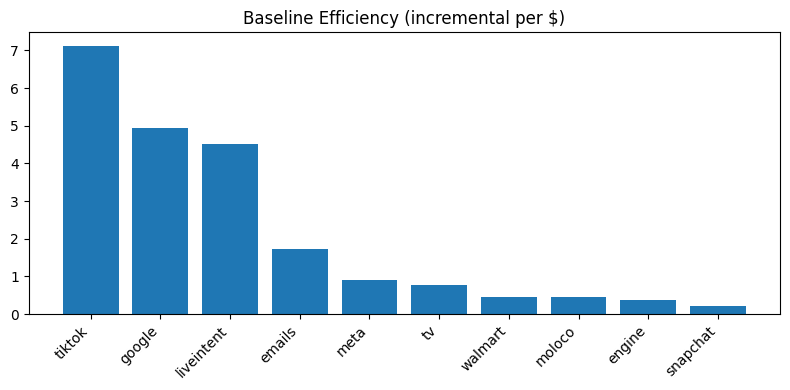

In [9]:
# --- Part C: Efficiency table from baseline (marginal-ish ranking near current spend) ---

import numpy as np, pandas as pd
import math

# 1) Pick whichever optimizer results you already have
use_opt = None
for cand in ["opt_fast", "opt_grp", "opt_results"]:
    if cand in globals():
        use_opt = globals()[cand]
        print(f"[info] Using optimizer results from `{cand}`")
        break
assert use_opt is not None, "Run an optimizer cell first (e.g., base, Part A, or Part B)."

# 2) Pull the NON-optimized (baseline) xarray -> DataFrame
base_df = use_opt.nonoptimized_data.to_dataframe().reset_index()

# 3) Detect the channel column robustly
def _detect_channel_col(df, known_channels):
    # best: exact overlap with known channel names
    for c in df.columns:
        vals = df[c].astype(str)
        if len(set(vals) & set(known_channels)) >= max(1, int(0.3*len(known_channels))):
            return c
    # fallback: any object column having any overlap
    for c in df.columns:
        if df[c].dtype == "O":
            vals = df[c].astype(str)
            if len(set(vals) & set(known_channels)) > 0:
                return c
    # last resort: a column literally called 'channel' if present
    if "channel" in df.columns:
        return "channel"
    # give up: pick the first object column
    obj_cols = [c for c in df.columns if df[c].dtype == "O"]
    return obj_cols[0] if obj_cols else df.columns[0]

ch_col = _detect_channel_col(base_df, channels)
base_df = base_df.rename(columns={ch_col: "channel"})

# 4) Figure out canonical metric column names present in your wheel
#    We’ll prefer 'incremental_outcome' and 'spend' if available.
spend_col = "spend" if "spend" in base_df.columns else None
incr_col_candidates = ["incremental_outcome", "incremental", "expected_incremental_outcome"]
incr_col = next((c for c in incr_col_candidates if c in base_df.columns), None)

# Minimal sanity
if spend_col is None or incr_col is None:
    print("[warn] Couldn’t find expected metric columns; showing raw baseline frame head().")
    display(base_df.head(20))
else:
    # 5) Aggregate across time/any extra dims to per-channel totals/means
    agg_spec = {spend_col: "sum", incr_col: "sum"}
    if "roi" in base_df.columns:  agg_spec["roi"]  = "mean"
    if "mroi" in base_df.columns: agg_spec["mroi"] = "mean"

    eff = (base_df
           .groupby("channel", as_index=False)
           .agg(agg_spec)
           .rename(columns={spend_col: "base_spend", incr_col: "base_incremental"}))

    # 6) Efficiency score (incremental per $ at baseline)
    eff["efficiency"] = eff["base_incremental"] / eff["base_spend"].replace(0, np.nan)

    # Optional: a quick z-score to spot outliers
    m, s = eff["efficiency"].mean(skipna=True), eff["efficiency"].std(skipna=True)
    eff["efficiency_z"] = (eff["efficiency"] - m) / (s if (s and not math.isclose(s,0.0)) else np.nan)

    # 7) Rank and show top 12
    eff_ranked = eff.sort_values("efficiency", ascending=False)
    print("=== Baseline efficiency (incremental per $) — top 12 ===")
    display(eff_ranked.head(12))

    # 8) (Optional) small bar chart — uncomment if you want a visual
    import matplotlib.pyplot as plt
    topk = eff_ranked.head(10)
    plt.figure(figsize=(8,4))
    plt.bar(topk["channel"], topk["efficiency"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Baseline Efficiency (incremental per $)")
    plt.tight_layout()
    plt.show()


In [10]:
# --- Part D: Tiny +2% budget what-if (fast, KPI-mode) ---

import numpy as np, pandas as pd
from meridian.analysis import optimizer

# 1) Pick the model to use (prefer the faster/most recent you've fit)
model_name = None
for cand in ["mmm_fast", "mmm_grp", "mmm"]:
    if cand in globals():
        model_name = cand
        m_use = globals()[cand]
        print(f"[info] Using model: {cand}")
        break
assert model_name is not None, "No Meridian model found. Run the base cell (or Part A/B) first."

# 2) Compute historical total budget from the right DataFrame/columns
if model_name == "mmm_grp" and "df_grp" in globals():
    # grouped case (Part B)
    media_cols_ref = globals().get("media_cols", None)
    if media_cols_ref is None:
        # fallback: infer from channels2 if present
        media_cols_ref = [c for c in df_grp.columns if c.endswith("_spend") or c == "other_spend"]
    hist_total_budget = float(df_grp[media_cols_ref].sum().sum())
else:
    # base / Part A case
    hist_total_budget = float(df[spend_cols].sum().sum())

# 3) +2% total budget, tight per-channel deviation (±10%)
bo = optimizer.BudgetOptimizer(m_use)
opt_2pct = bo.optimize(
    budget=hist_total_budget * 1.02,
    use_kpi=True,
    spend_constraint_lower=0.10,
    spend_constraint_upper=0.10,
)

# 4) Helper to tidy optimizer outputs (reuse if already defined)
def _opt_table(opt_results, channels_guess=None):
    d1 = opt_results.optimized_data.to_dataframe().reset_index()
    d0 = opt_results.nonoptimized_data.to_dataframe().reset_index()

    # detect channel column robustly
    ch_col = None
    # try known channel lists if provided in the session
    known_sets = []
    if channels_guess is not None: known_sets.append(set(channels_guess))
    if "channels2" in globals(): known_sets.append(set(globals()["channels2"]))
    if "channels" in globals():  known_sets.append(set(globals()["channels"]))
    known_sets.append(set([str(x) for x in d1.select_dtypes("object").stack().unique()]))

    for c in d1.columns:
        vals = set(d1[c].astype(str).unique())
        if any(vals & ks for ks in known_sets if ks):
            ch_col = c; break
    if ch_col is None:
        obj_cols = [c for c in d1.columns if d1[c].dtype == "O"]
        ch_col = obj_cols[0] if obj_cols else d1.columns[0]

    d1 = d1.rename(columns={ch_col: "channel"})
    d0 = d0.rename(columns={ch_col: "channel"})

    keep = ["spend","incremental_outcome","roi","mroi","percentage_of_spend"]
    v1 = d1[["channel"]+[c for c in keep if c in d1.columns]].rename(columns={c: f"opt_{c}" for c in keep if c in d1.columns})
    v0 = d0[["channel"]+[c for c in keep if c in d0.columns]].rename(columns={c: f"base_{c}" for c in keep if c in d0.columns})
    out = v0.merge(v1, on="channel", how="outer")

    if {"base_spend","opt_spend"}.issubset(out.columns):
        out["delta_spend"] = out["opt_spend"] - out["base_spend"]
    if {"base_incremental_outcome","opt_incremental_outcome"}.issubset(out.columns):
        out["delta_incremental"] = out["opt_incremental_outcome"] - out["base_incremental_outcome"]
    return out

# 5) Try to pass a reasonable channel list for nicer labeling
channels_guess = None
if model_name == "mmm_grp" and "channels2" in globals():
    channels_guess = globals()["channels2"]
elif "channels" in globals():
    channels_guess = globals()["channels"]

tab_2pct = _opt_table(opt_2pct, channels_guess)
print("=== +2% budget what-if (ranked by delta_incremental if available) ===")
if "delta_incremental" in tab_2pct.columns:
    display(tab_2pct.sort_values("delta_incremental", ascending=False).head(12))
else:
    display(tab_2pct.head(12))


[info] Using model: mmm_fast
=== +2% budget what-if (ranked by delta_incremental if available) ===


,channel,base_spend,base_incremental_outcome,base_roi,base_mroi,opt_spend,opt_incremental_outcome,opt_roi,opt_mroi,delta_spend,delta_incremental
80,google,10500000,52275268.0,4.978628,3.605576,11060000,54272772.0,4.907105,3.509884,560000,1997504.0
83,google,10500000,52275268.0,4.978628,3.605576,11060000,54272632.0,4.907110,3.509873,560000,1997364.0
81,google,10500000,52275268.0,4.978628,3.605576,11060000,54272632.0,4.907110,3.509873,560000,1997364.0
82,google,10500000,52275268.0,4.978628,3.605576,11060000,54272632.0,4.907110,3.509873,560000,1997364.0
88,google,10500000,52275416.0,4.978611,3.605562,11060000,54272772.0,4.907105,3.509884,560000,1997356.0
92,google,10500000,52275416.0,4.978611,3.605562,11060000,54272772.0,4.907105,3.509884,560000,1997356.0
84,google,10500000,52275416.0,4.978611,3.605562,11060000,54272772.0,4.907105,3.509884,560000,1997356.0
95,google,10500000,52275416.0,4.978611,3.605562,11060000,54272632.0,4.907110,3.509873,560000,1997216.0
85,google,10500000,52275416.0,4.978611,3.605562,11060000,54272632.0,4.907110,3.509873,560000,1997216.0
94,google,10500000,52275416.0,4.978611,3.605562,11060000,54272632.0,4.907110,3.509873,560000,1997216.0


/usr/local/lib/python3.12/dist-packages/meridian/analysis/analyzer.py:606: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


[info] No media summary table found; using optimizer table instead if available.


,channel,base_spend,base_incremental_outcome,base_roi,base_mroi,opt_spend,opt_incremental_outcome,opt_roi,opt_mroi,delta_spend,delta_incremental
155,snapchat,4560000,64038.480469,0.014044,0.006666,5300000,357816.031250,0.067512,0.027005,740000,293777.562500
91,google,10810000,244757.312500,0.022642,0.011057,11170000,530749.062500,0.047516,0.019889,360000,285991.750000
151,snapchat,4560000,175537.046875,0.038495,0.018470,5300000,357816.031250,0.067512,0.027005,740000,182278.984375
147,snapchat,4560000,184799.828125,0.040526,0.018637,5300000,357816.031250,0.067512,0.027005,740000,173016.203125
87,google,10810000,369908.468750,0.034219,0.016921,11170000,530749.062500,0.047516,0.019889,360000,160840.593750
83,google,10810000,375170.656250,0.034706,0.016522,11170000,530749.062500,0.047516,0.019889,360000,155578.406250
88,google,10810000,244757.312500,0.022642,0.011057,11170000,381054.875000,0.034114,0.016022,360000,136297.562500
152,snapchat,4560000,64038.480469,0.014044,0.006666,5300000,197650.609375,0.037293,0.016029,740000,133612.125000
89,google,10810000,244757.312500,0.022642,0.011057,11170000,375659.125000,0.033631,0.016394,360000,130901.812500
153,snapchat,4560000,64038.480469,0.014044,0.006666,5300000,189605.781250,0.035775,0.015909,740000,125567.296875


Plotting local response for: ['google', 'snapchat', 'tiktok']


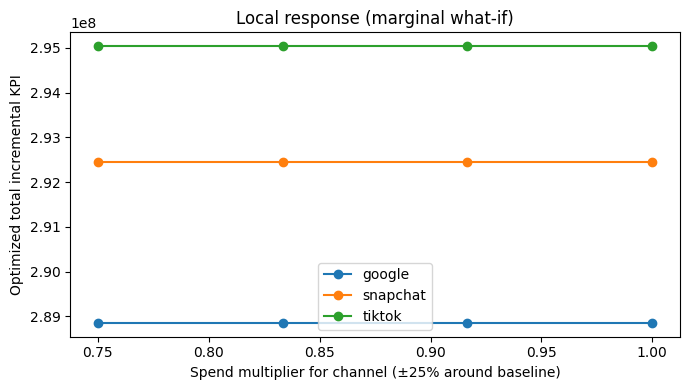

In [11]:
# --- Part E: Meridian diagnostics + quick response curves ---

import numpy as np, pandas as pd
from meridian.analysis import visualizer, summarizer

# 1) Core diagnostics (try/except to survive wheel diffs)
try:
    _ = visualizer.ModelDiagnostics(mmm).plot_rhat_boxplot()
except Exception as e:
    print("[info] Rhat boxplot not available on this wheel:", e)

try:
    _ = visualizer.ModelFit(mmm).plot_model_fit()
except Exception as e:
    print("[info] Model fit plot not available on this wheel:", e)

# 2) Channel summary table (works if your wheel exposes any of these)
sumr = summarizer.Summarizer(mmm)
summary_df = None
for name in ["get_media_summary", "media_summary", "get_media_effects", "media_effects_summary", "get_channel_summary"]:
    if hasattr(sumr, name):
        try:
            tbl = getattr(sumr, name)()
            summary_df = tbl.to_pandas() if hasattr(tbl, "to_pandas") else (tbl if isinstance(tbl, pd.DataFrame) else None)
            if summary_df is not None:
                break
        except Exception:
            pass

if summary_df is not None:
    from IPython.display import display
    # sort by an intuitive column if present
    for c in ["incremental_mean","incremental","mean_incremental","roi","mroi"]:
        if c in summary_df.columns:
            display(summary_df.sort_values(c, ascending=False).head(12))
            break
else:
    print("[info] No media summary table found; using optimizer table instead if available.")
    try:
        display(alloc_compare.sort_values("delta_incremental", ascending=False).head(12))
    except Exception:
        print("[info] Run the earlier optimization cell first to get alloc_compare.")

# 3) “Local response” curves (quick marginal what-if for top channels)
#    For the top 3 channels by baseline spend, nudge ±25% and reopt within tight bounds
from meridian.analysis import optimizer
import matplotlib.pyplot as plt

# pick a model to use (prefer the one with controls if present)
m_use = mmm_fast if 'mmm_fast' in globals() else (mmm_grp if 'mmm_grp' in globals() else mmm)

# choose the reference DataFrame for historical baseline
if m_use is mmm_grp and 'df_grp' in globals():
    ref_df = df_grp.copy()
    media_cols_ref = [c for c in ref_df.columns if c.endswith("_spend") or c == "other_spend"]
    ch_names = [c.replace("_spend","") for c in media_cols_ref]
else:
    ref_df = df.copy()
    media_cols_ref = spend_cols
    ch_names = channels

base_spend = ref_df[media_cols_ref].sum()
top3_cols = list(base_spend.sort_values(ascending=False).head(3).index)
top3 = [c.replace("_spend","") for c in top3_cols]
print("Plotting local response for:", top3)

bo = optimizer.BudgetOptimizer(m_use)
total_budget = float(ref_df[media_cols_ref].sum().sum())

def one_channel_curve(col, steps=7, width=0.25):
    # vary this channel's budget ±width around baseline; keep others ±5%
    grid = np.linspace(1.0 - width, 1.0 + width, steps)
    rows = []
    for g in grid:
        # requested total budget equals original total (so optimizer can move within constraints)
        # per-channel constraints:
        lower = []
        upper = []
        # build constraints aligned to channel order in the model (ch_names)
        for c in ch_names:
            if c == col.replace("_spend",""):
                lower.append(max(0.0, g-0.001))  # ~fix to g
                upper.append(max(0.0, g-0.001))
            else:
                lower.append(0.05)  # allow small wiggle
                upper.append(0.05)
        try:
            res = bo.optimize(
                budget=total_budget,
                use_kpi=True,
                spend_constraint_lower=lower,
                spend_constraint_upper=upper,
            )
            # pull this channel's spend & incremental outcome after optimize
            odf = res.optimized_data.to_dataframe().reset_index()
            # detect channel column
            ch_col = None
            for k in odf.columns:
                vals = set(odf[k].astype(str))
                if len(vals & set(ch_names)) > 0: ch_col = k; break
            if ch_col is None:
                ch_col = [k for k in odf.columns if odf[k].dtype == 'O'][0]
            odf = odf.rename(columns={ch_col:"channel"})
            row = {
                "multiplier": g,
                "total_incremental": odf.get("incremental_outcome", pd.Series([np.nan])).sum(),
                "channel": col.replace("_spend","")
            }
            # optional: grab the focal channel's spend
            me = odf[odf["channel"] == col.replace("_spend","")]
            if not me.empty and "spend" in me.columns:
                row["spend"] = float(me["spend"].iloc[0])
            rows.append(row)
        except Exception as e:
            rows.append({"multiplier": g, "total_incremental": np.nan, "channel": col.replace("_spend","")})
    return pd.DataFrame(rows)

# build curves & plot
curves = []
for col in top3_cols:
    curves.append(one_channel_curve(col))
curves = pd.concat(curves, ignore_index=True)

fig, ax = plt.subplots(figsize=(7,4))
for ch in curves["channel"].unique():
    sub = curves[curves["channel"] == ch].sort_values("multiplier")
    ax.plot(sub["multiplier"], sub["total_incremental"], marker='o', label=ch)
ax.set_xlabel("Spend multiplier for channel (±25% around baseline)")
ax.set_ylabel("Optimized total incremental KPI")
ax.set_title("Local response (marginal what-if)")
ax.legend()
plt.tight_layout()
plt.show()


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.087,4.480,-8.345,7.710,0.143,0.162,955.119,636.895,1.000
mu_theta,0.086,0.966,-1.669,2.015,0.030,0.031,999.595,571.105,0.999
tau_theta,1.178,1.459,0.001,3.196,0.043,0.195,887.080,277.150,1.004
sigma,2505.656,200.011,2158.294,2879.389,6.966,6.989,843.402,584.675,1.002
beta_ctrl[0],0.026,1.022,-1.879,2.048,0.035,0.039,812.248,489.596,1.007
beta_ctrl[1],0.023,0.996,-1.946,1.785,0.034,0.037,879.676,503.835,1.002
beta_ctrl[2],0.038,1.064,-2.097,2.055,0.035,0.041,957.297,647.992,1.009
theta[0],0.140,2.547,-3.811,3.163,0.091,0.555,866.922,664.687,1.000
theta[1],0.119,1.923,-3.046,3.645,0.073,0.133,782.300,690.832,1.006
theta[2],0.213,1.948,-2.879,4.337,0.072,0.103,775.926,621.257,1.001


[info] Posterior width 800 != design width 7. Aligning by truncation.
=== Random-slope (mixed) posterior for standardized channel multipliers ===


,channel,theta_mean,theta_hdi_low,theta_hdi_high
0,google,1.560530,0.459989,2.615919
2,tiktok,1.419244,-0.526103,5.533373
3,engine,-0.322802,-0.518387,-0.216881
5,meta,-0.352517,-0.656973,-0.136345
1,snapchat,-1.078480,-1.165471,-0.963648
6,other,-1.446272,-1.929736,-0.803685
4,moloco,-2.087460,-8.774137,3.183796


=== Local efficiency (slope * avg adstocked spend, original units) ===


,channel,local_eff_mean
0,google,525588.723030
2,tiktok,83189.855290
5,meta,-8621.566207
3,engine,-14415.051630
4,moloco,-57634.706338
6,other,-61297.878969
1,snapchat,-151919.821774


Output()

<Axes: xlabel='y_obs'>

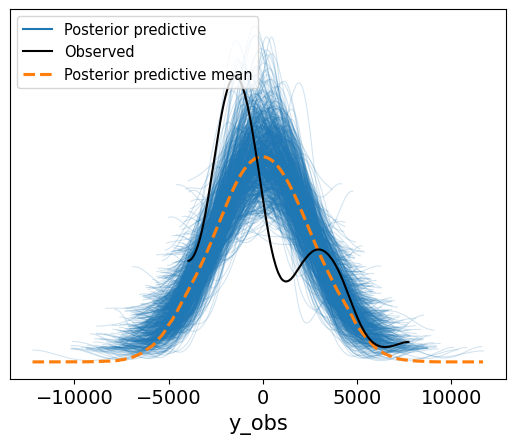

In [18]:
# --- Bayesian Linear Mixed MMM (PyMC, STA721-style) — aligned, <1000 draws, clean PPC ---

import numpy as np, pandas as pd
import pymc as pm
import arviz as az

# 0) Helpers
def geometric_adstock(x, alpha=0.6, max_lag=8):
    x = np.asarray(x, dtype=float)
    T = len(x)
    out = np.zeros(T, dtype=float)
    w = np.array([alpha**k for k in range(max_lag+1)], dtype=float)
    for t in range(T):
        k = min(max_lag, t)
        out[t] = (x[t-k:t+1][::-1] * w[:k+1]).sum()
    return out

def zscore_cols(M):
    M = np.asarray(M, dtype=float)
    mu = M.mean(axis=0, keepdims=True)
    sd = M.std(axis=0, keepdims=True)
    sd = np.where(sd == 0, 1.0, sd)
    return (M - mu) / sd, mu.ravel(), sd.ravel()

# 1) Build design from whatever active DataFrame/columns you’re using now.
# Prefer grouped Part B if present; otherwise fall back to base data.
if "df_grp" in globals() and "media_cols" in globals():
    df_use = df_grp
    cols_use = media_cols[:]  # includes 'other_spend' if created
else:
    df_use = df
    cols_use = spend_cols[:]

# Channel names aligned to columns in use
ch_names = [c.replace("_spend","") for c in cols_use]

# Adstocked (original units) and standardized versions
X_raw = np.column_stack([geometric_adstock(df_use[c].values, alpha=0.6, max_lag=8) for c in cols_use])
X, X_mu, X_sd = zscore_cols(X_raw)

y = df_use["subscriptions"].values.astype(float)
y_c = y - y.mean()

# Controls (trend + seasonality) on the same df_use, standardized
t = np.arange(len(df_use))
C_raw = np.column_stack([
    (t - t.mean())/t.std(),
    np.sin(2*np.pi*df_use["time"].dt.month.values/12.0),
    np.cos(2*np.pi*df_use["time"].dt.month.values/12.0),
])
C, C_mu, C_sd = zscore_cols(C_raw)
ctrl_names = ["trend","s_sin","s_cos"]

T, J = X.shape
assert J == len(ch_names), f"Design width J={J} but ch_names={len(ch_names)}."

# 2) Non-centered hierarchical mixed model
with pm.Model() as m_lmm:
    mu_theta   = pm.Normal("mu_theta", 0.0, 1.0)
    tau_theta  = pm.HalfStudentT("tau_theta", nu=3, sigma=1.0)

    theta_offset = pm.Normal("theta_offset", 0.0, 1.0, shape=J)
    theta        = pm.Deterministic("theta", mu_theta + tau_theta * theta_offset)

    intercept  = pm.Normal("intercept", 0.0, 5.0)
    beta_ctrl  = pm.Normal("beta_ctrl", 0.0, 1.0, shape=C.shape[1])

    sigma      = pm.HalfStudentT("sigma", nu=3, sigma=5.0)

    mu = intercept + pm.math.dot(X, theta) + pm.math.dot(C, beta_ctrl)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_c)

    # Sampling (<1000 draws per chain)
    trace_lmm = pm.sample(
        draws=400,      # < 1000 per chain
        tune=600,
        chains=2,
        target_accept=0.95,
        max_treedepth=12,
        random_seed=7,
        progressbar=True,
    )

# 3) Summary
display(az.summary(trace_lmm, var_names=["intercept","mu_theta","tau_theta","sigma","beta_ctrl","theta"], round_to=3))

# 4) Posterior → align shapes robustly
post = az.extract(trace_lmm)
theta_post = post["theta"].to_numpy()        # (draws, J_est)
J_est = theta_post.shape[1]

# Align in case upstream design changed
if J_est != J:
    print(f"[info] Posterior width {J_est} != design width {J}. Aligning by truncation.")
    J_final = min(J_est, J)
    theta_post = theta_post[:, :J_final]
    X_raw = X_raw[:, :J_final]
    ch_names_aligned = ch_names[:J_final]
else:
    J_final = J
    ch_names_aligned = ch_names

theta_mean = theta_post.mean(axis=0)

# Per-channel HDIs (works across ArviZ versions)
theta_hdi = np.empty((J_final, 2), dtype=float)
for j in range(J_final):
    h = np.asarray(az.hdi(theta_post[:, j], hdi_prob=0.95)).reshape(-1)
    theta_hdi[j, 0], theta_hdi[j, 1] = h[0], h[1]

# Channel table
ch_table = (
    pd.DataFrame({
        "channel": ch_names_aligned,
        "theta_mean": theta_mean,
        "theta_hdi_low": theta_hdi[:, 0],
        "theta_hdi_high": theta_hdi[:, 1],
    })
    .sort_values("theta_mean", ascending=False)
)
print("=== Random-slope (mixed) posterior for standardized channel multipliers ===")
display(ch_table)

# 5) Local “efficiency” near baseline (slope * avg adstocked spend, original units)
eff = []
for j, ch in enumerate(ch_names_aligned):
    eff.append({
        "channel": ch,
        "local_eff_mean": float(theta_mean[j] * X_raw[:, j].mean())
    })
eff = pd.DataFrame(eff).sort_values("local_eff_mean", ascending=False)
print("=== Local efficiency (slope * avg adstocked spend, original units) ===")
display(eff.head(12))

# 6) Posterior predictive (InferenceData) + clean PPC
with m_lmm:
    ppc_idata = pm.sample_posterior_predictive(
        trace_lmm,
        var_names=["y_obs"],
        return_inferencedata=True,
        random_seed=7,
    )

# Attach observed data only if it's not already present
if "observed_data" not in ppc_idata._groups_all:
    ppc_idata.add_groups({"observed_data": {"y_obs": y_c}})

az.plot_ppc(ppc_idata)
